In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
Guangzhou = pd.read_csv("/FiveCitiePMData/GuangzhouPM20100101_20151231.csv")


In [3]:
Guangzhou.drop(['PM_City Station', 'PM_5th Middle School','season', 'precipitation', 'Iprec', 'cbwd'], 
               axis=1,
              inplace=True)


In [4]:
Guangzhou.dropna(axis=0, how="any", inplace=True)
Guangzhou['Time'] = pd.to_datetime(Guangzhou['year'].map(str) +"/"+ Guangzhou['month'].map(str) +"/"+ Guangzhou['day'].map(str)+" "+Guangzhou['hour'].map(str)+":00:00")


In [5]:
Guangzhou_1 = Guangzhou.groupby(['Time']).mean()


In [6]:
Guangzhou_1.index = pd.to_datetime(Guangzhou_1.index, 
                             format='%d-%m-%Y %H:%M:%S')
Guangzhou_1 = Guangzhou_1.set_index(Guangzhou_1.index).asfreq('H')
Guangzhou_1 = Guangzhou_1.fillna(method='ffill')
Guangzhou_1['Time'] = Guangzhou_1.index


In [7]:
Guangzhou_13 = Guangzhou_1[(Guangzhou_1['Time'] >=pd.to_datetime('20130501030000')) & (Guangzhou_1['Time'] <= pd.to_datetime('20150430030000'))]
Guangzhou_13 = Guangzhou_13.set_index(Guangzhou_13.index).asfreq('D')



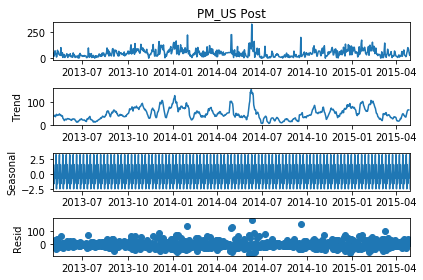

In [8]:
split_result = seasonal_decompose(Guangzhou_13['PM_US Post'],  
                            model ='additive') 
split_result.plot();

In [9]:
# Split data into train / test sets 
dataset = Guangzhou_13[['PM_US Post','DEWP','HUMI','PRES', 'TEMP', 'Iws']]
train = dataset[:len(dataset)-146]
test = dataset[len(dataset)-146:]

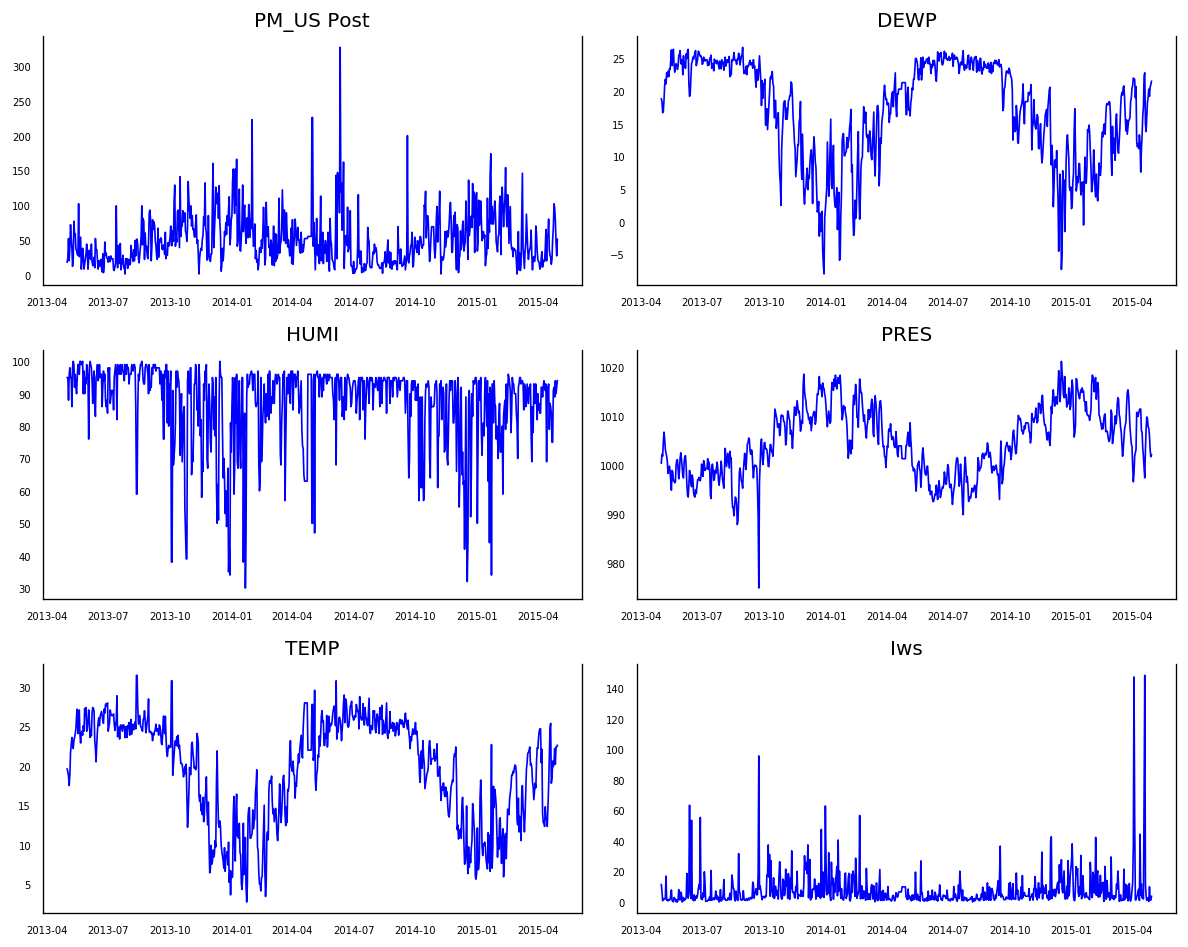

In [10]:
#preliminary plots of each variable
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

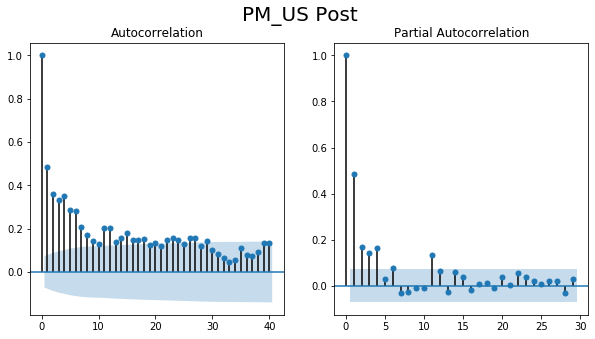

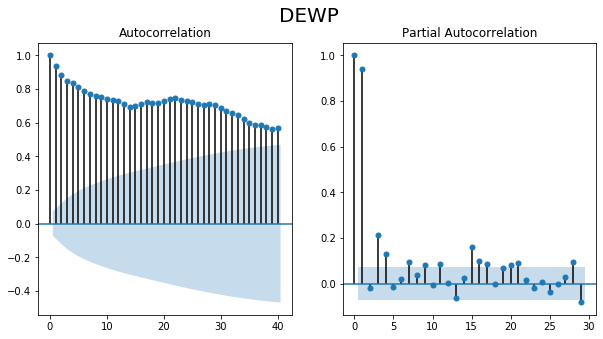

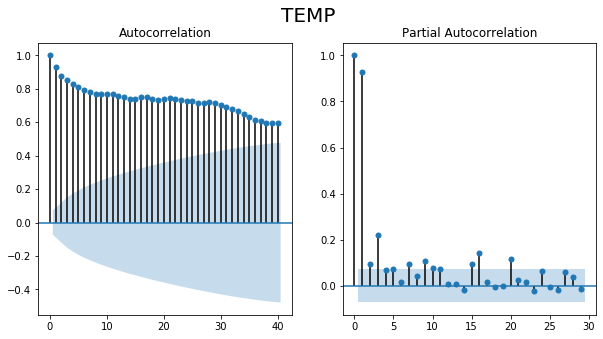

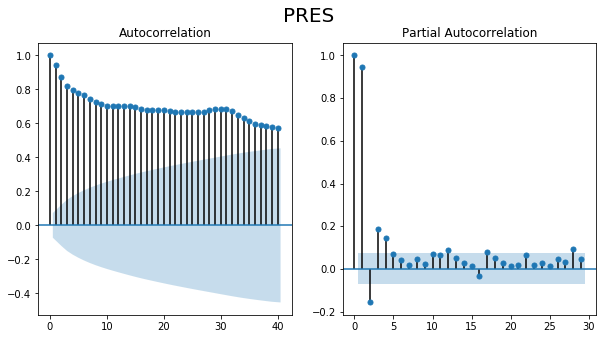

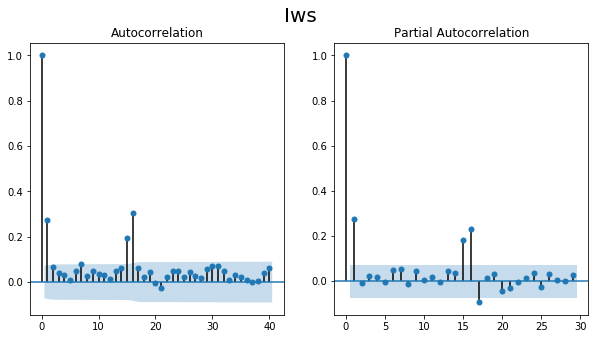

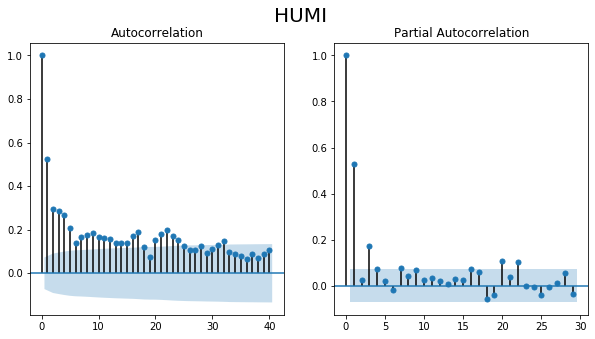

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PM_US Post', fontsize=20)
ax[0] = plot_acf(dataset['PM_US Post'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PM_US Post'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('DEWP', fontsize=20)
ax[0] = plot_acf(dataset['DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('TEMP', fontsize=20)
ax[0] = plot_acf(dataset['TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PRES', fontsize=20)
ax[0] = plot_acf(dataset['PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Iws', fontsize=20)
ax[0] = plot_acf(dataset['Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('HUMI', fontsize=20)
ax[0] = plot_acf(dataset['HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['HUMI'], ax = ax[1])

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(dataset, variables = dataset.columns) 

,PM_US Post_x,DEWP_x,HUMI_x,PRES_x,TEMP_x,Iws_x
PM_US Post_y,1.0000,0.0000,0.0004,0.0000,0.0000,0.2074
DEWP_y,0.0000,1.0000,0.0000,0.0541,0.0000,0.0049
HUMI_y,0.0020,0.0000,1.0000,0.0000,0.0000,0.1004
PRES_y,0.0002,0.0000,0.0151,1.0000,0.0000,0.5057
TEMP_y,0.0000,0.0000,0.0000,0.0369,1.0000,0.0000
Iws_y,0.0182,0.3847,0.1408,0.1273,0.3874,0.9330


In [12]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dataset)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
PM_US Post ::  384.77    > 83.9383   =>   True
DEWP   ::  265.42    > 60.0627   =>   True
HUMI   ::  161.17    > 40.1749   =>   True
PRES   ::  65.36     > 24.2761   =>   True
TEMP   ::  8.44      > 12.3212   =>   False
Iws    ::  0.0       > 4.1296    =>   False


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5186
 No. Lags Chosen       = 10
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0482
 No. Lags Chosen       = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.7353. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

In [14]:
train_diff = train.diff().dropna()
train_diff

,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws
Time,,,,,,
2013-05-02 03:00:00,6.0,-0.4,0.0,1.8,-0.4,-4.4
2013-05-03 03:00:00,28.0,-1.7,-7.0,-0.4,-0.5,-6.2
2013-05-04 03:00:00,-32.0,0.2,8.0,2.9,-1.2,1.4
2013-05-05 03:00:00,21.0,1.7,2.0,2.0,1.4,-0.1
2013-05-06 03:00:00,31.0,2.3,-3.0,-1.5,2.8,-0.3
...,...,...,...,...,...,...
2014-12-01 03:00:00,-23.0,-8.5,-24.0,2.8,-3.8,38.2
2014-12-02 03:00:00,65.0,-3.4,15.0,5.1,-6.7,2.7
2014-12-03 03:00:00,-5.0,3.0,14.0,-1.4,0.6,-40.4


In [15]:
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1178
 No. Lags Chosen       = 13
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1306
 No. Lags Chosen       = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [16]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff)
    
x = model.select_order(maxlags=30)
x.summary()
#min AIC/FPE: lag 11

,AIC,BIC,FPE,HQIC
0,18.22,18.26,8.166e+07,18.24
1,17.60,17.93,4.391e+07,17.73
2,17.16,17.77*,2.834e+07,17.40
3,16.97,17.86,2.341e+07,17.32*
4,16.96,18.14,2.333e+07,17.42
5,16.96,18.41,2.323e+07,17.53
6,16.98,18.71,2.363e+07,17.65
7,16.98,18.99,2.363e+07,17.76
8,17.00,19.29,2.414e+07,17.89
9,16.89,19.46,2.172e+07,17.90


In [17]:
results = model.fit(maxlags=30, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, May, 2020
Time:                     17:18:04
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    19.7504
Nobs:                     572.000    HQIC:                   17.8862
Log likelihood:          -9242.23    FPE:                1.78996e+07
AIC:                      16.6938    Det(Omega_mle):     9.20906e+06
--------------------------------------------------------------------
Results for equation PM_US Post
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.153449         1.295158           -0.118           0.906
L1.PM_US Post         -0.629620         0.045491          -13.840           0.000
L1.DEWP               -1.770446         4.434322   

In [18]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic: [0,4]; 
#close to 2 = no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(train_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

PM_US Post : 2.01
DEWP   : 1.99
HUMI   : 1.98
PRES   : 2.01
TEMP   : 2.01
Iws    : 2.0


In [19]:
# Get the lag order
lag_order = results.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]

#results.forecast(dataset.values[-lag_order:], 30)
fc = results.forecast(y=forecast_input, steps=15)
result_forecast = pd.DataFrame(fc, index=dataset.index[-15:], columns=dataset.columns + '_1d')
#print(result_forecast)

In [20]:
def invert_transformation(train, result_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = result_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+ '_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train, result_forecast)       


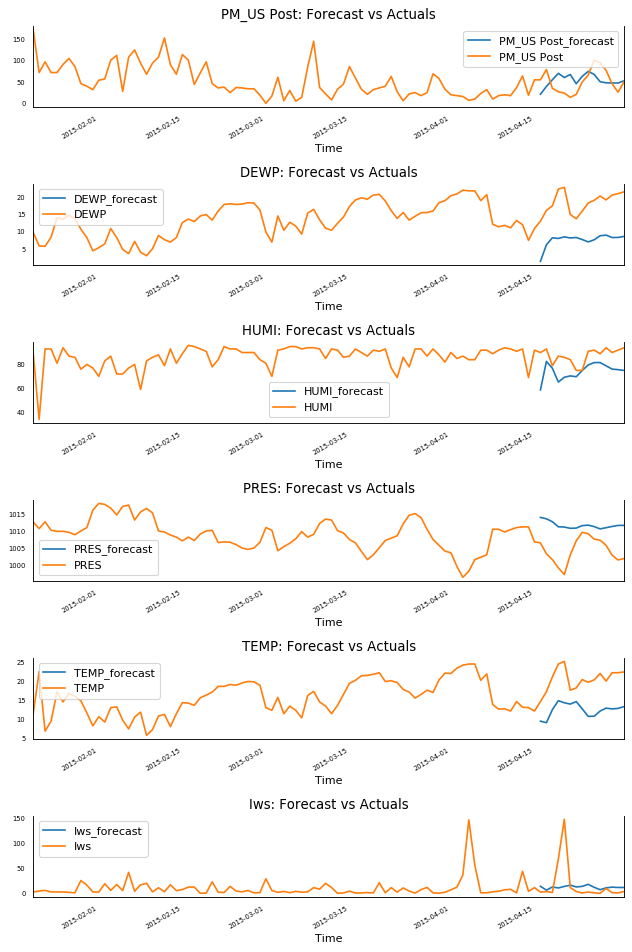

In [21]:
#results.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [22]:
test = dataset[len(dataset)-146:]

In [23]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test[['PM_US Post', 'DEWP','HUMI','PRES', 'TEMP', 'Iws']][-15:], 
                                  df_results[['PM_US Post_forecast','DEWP_forecast','HUMI_forecast','PRES_forecast', 'TEMP_forecast', 'Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse)

Overall RMSE:  22.211053200938988


In [24]:
rmse_PM = np.sqrt(mean_squared_error(test[['PM_US Post']][-15:], 
                                  df_results[['PM_US Post_forecast']][-15:]))
print("RMSE for Guangzhou_PM2.5_forecast: ", rmse_PM)

rmse_DEWP = np.sqrt(mean_squared_error(test[['DEWP']][-15:], 
                                  df_results[['DEWP_forecast']][-15:]))
print("RMSE for DEWP_forecast: ", rmse_DEWP)

rmse_HUMI = np.sqrt(mean_squared_error(test[['HUMI']][-15:], 
                                  df_results[['HUMI_forecast']][-15:]))
print("RMSE for HUMI_forecast: ", rmse_HUMI)

rmse_PRES = np.sqrt(mean_squared_error(test[['PRES']][-15:], 
                                  df_results[['PRES_forecast']][-15:]))
print("RMSE for PRES_forecast: ", rmse_PRES)

rmse_TEMP = np.sqrt(mean_squared_error(test[['TEMP']][-15:], 
                                  df_results[['TEMP_forecast']][-15:]))
print("RMSE for TEMP_forecast: ", rmse_TEMP)

rmse_Iws = np.sqrt(mean_squared_error(test[['Iws']][-15:], 
                                  df_results[['Iws_forecast']][-15:]))
print("RMSE for Iws_forecast ", rmse_Iws)

RMSE for Guangzhou_PM2.5_forecast:  30.9750693257367
RMSE for DEWP_forecast:  10.986413883600136
RMSE for HUMI_forecast:  15.081382318905636
RMSE for PRES_forecast:  8.28002585153498
RMSE for TEMP_forecast:  8.369158017837115
RMSE for Iws_forecast  38.90731768363224


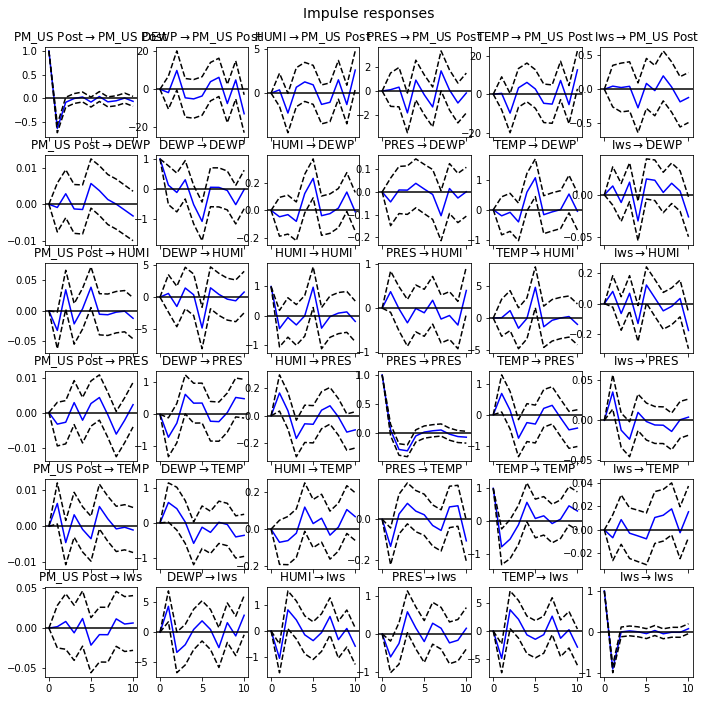

In [25]:
#impulse response analysis
irf = results.irf(10)
irf.plot(orth=False);

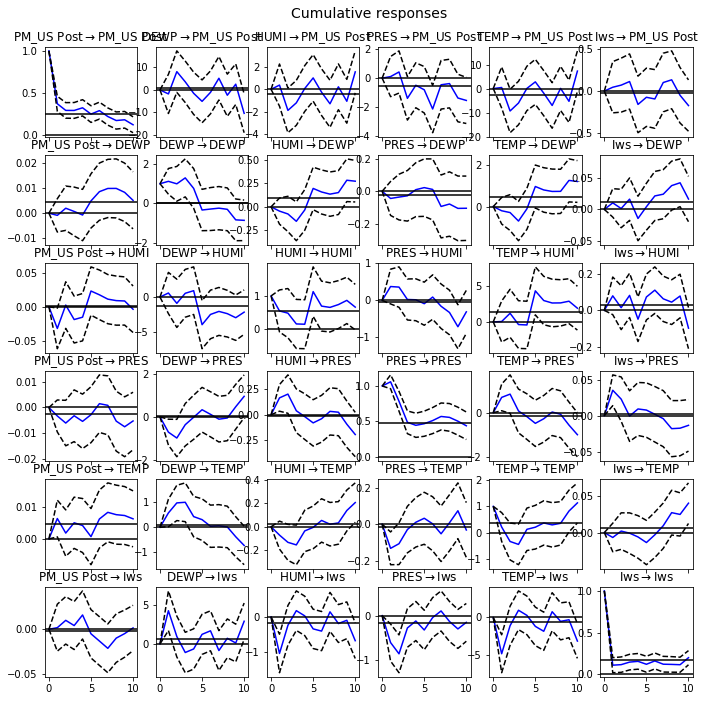

In [26]:
#impulse response analysis wiht cumulative effect
irf.plot_cum_effects(orth=False);

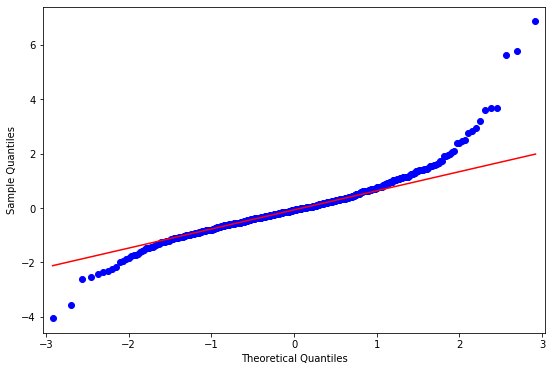

In [27]:
resid = results.resid['PM_US Post']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [28]:
#Forecast Error Variance Decomposition (FEVD) method
fevd = results.fevd(5)
fevd.summary()

FEVD for PM_US Post
     PM_US Post      DEWP      HUMI      PRES      TEMP       Iws
0      1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1      0.994843  0.001247  0.003779  0.000010  0.000005  0.000116
2      0.985636  0.002274  0.004405  0.000602  0.006934  0.000150
3      0.972943  0.003750  0.004613  0.010914  0.007531  0.000248
4      0.960519  0.005727  0.004667  0.013811  0.011017  0.004260

FEVD for DEWP
     PM_US Post      DEWP      HUMI      PRES      TEMP       Iws
0      0.036613  0.963387  0.000000  0.000000  0.000000  0.000000
1      0.037142  0.958342  0.000038  0.001801  0.001104  0.001571
2      0.035056  0.957663  0.001701  0.001919  0.001083  0.002578
3      0.036572  0.948219  0.003043  0.001884  0.004780  0.005502
4      0.035674  0.926048  0.003652  0.003867  0.013065  0.017694

FEVD for HUMI
     PM_US Post      DEWP      HUMI      PRES      TEMP       Iws
0      0.005036  0.409807  0.585158  0.000000  0.000000  0.000000
1      0.015287  0.381463 

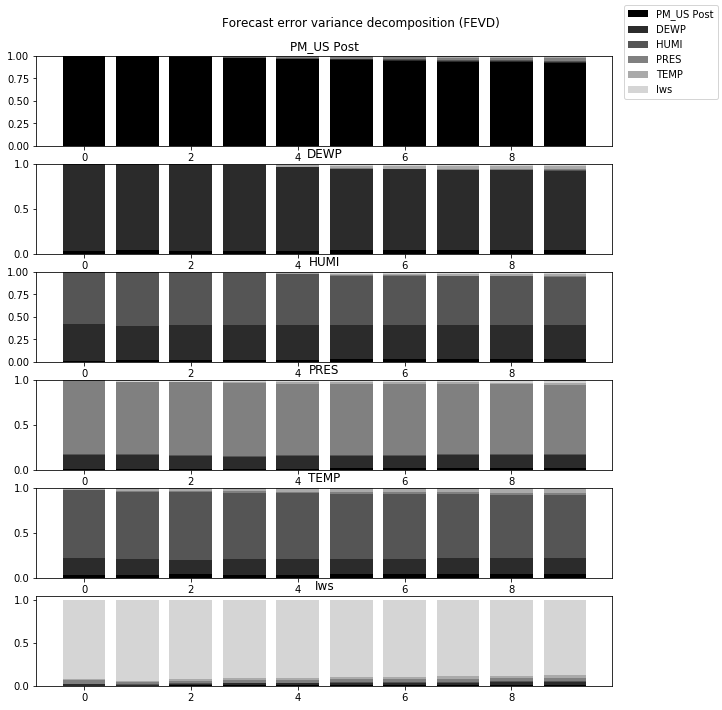

In [29]:
results.fevd(10).plot();